In [ ]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join('..')))

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from app.database.connection import SessionLocal
db = SessionLocal()


from app.ml.data_loader import load_inventory_dataset

df = load_inventory_dataset(db)
df.head()

Not enough inventory rows (4), creating dataset from stock history


,pharmacy_id,medication_id,quantity,old_quantity,new_quantity,changed_at
0,1,1,5,20,5,2026-02-09 21:55:19.647410
1,1,2,30,40,30,2026-02-09 21:55:19.657839
2,2,1,8,15,8,2026-02-09 21:55:19.657896
3,2,3,50,55,50,2026-02-09 21:55:19.657918


In [2]:
SHORTAGE_THRESHOLD = 10

df["shortage"] = (df["quantity"] <= SHORTAGE_THRESHOLD).astype(int)

In [3]:
## 1. Dataset Overview
df.info()
df.describe()


<class 'pandas.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   pharmacy_id    4 non-null      int64         
 1   medication_id  4 non-null      int64         
 2   quantity       4 non-null      int64         
 3   old_quantity   4 non-null      int64         
 4   new_quantity   4 non-null      int64         
 5   changed_at     4 non-null      datetime64[us]
 6   shortage       4 non-null      int64         
dtypes: datetime64[us](1), int64(6)
memory usage: 356.0 bytes


,pharmacy_id,medication_id,quantity,old_quantity,new_quantity,changed_at,shortage
count,4.00000,4.000000,4.000000,4.000000,4.000000,4,4.00000
mean,1.50000,1.750000,23.250000,32.500000,23.250000,2026-02-09 21:55:19.655265,0.50000
min,1.00000,1.000000,5.000000,15.000000,5.000000,2026-02-09 21:55:19.647410,0.00000
25%,1.00000,1.000000,7.250000,18.750000,7.250000,2026-02-09 21:55:19.655231,0.00000
50%,1.50000,1.500000,19.000000,30.000000,19.000000,2026-02-09 21:55:19.657867,0.50000
75%,2.00000,2.250000,35.000000,43.750000,35.000000,2026-02-09 21:55:19.657901,1.00000
max,2.00000,3.000000,50.000000,55.000000,50.000000,2026-02-09 21:55:19.657918,1.00000
std,0.57735,0.957427,21.029741,18.484228,21.029741,NaN,0.57735


In [4]:
## 2. Data Quality Checks
df.isnull().sum()
df.duplicated().sum()

np.int64(0)

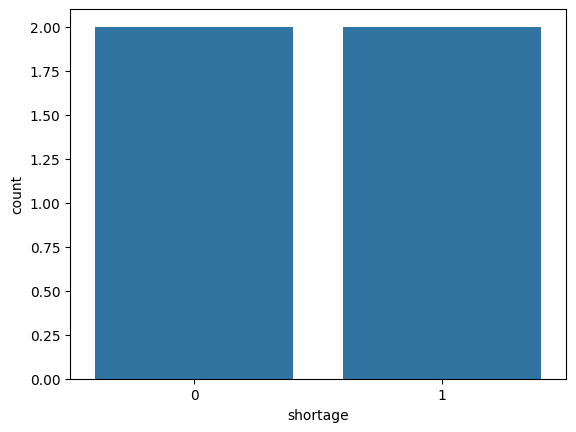

In [5]:
## 3. Target Variable Analysis
df["shortage"].value_counts()
sns.countplot(x="shortage", data=df)
plt.show()

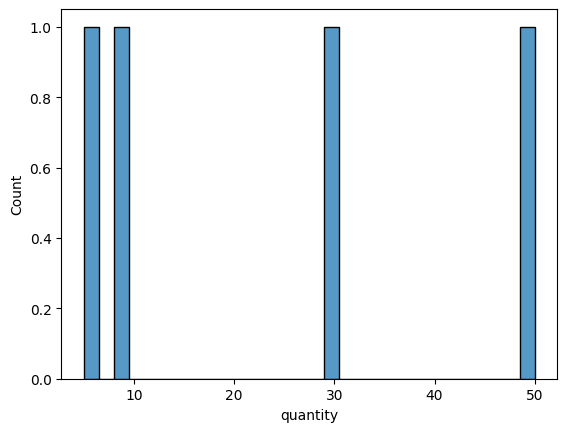

In [6]:
## 4. Stock & Demand Analysis
sns.histplot(df["quantity"], bins=30)
plt.show()

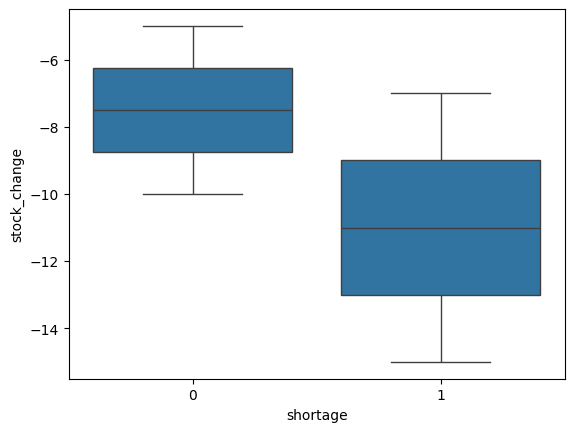

In [7]:
## 5. Supplier Delay Impact
df["stock_change"] = df["new_quantity"] - df["old_quantity"]
sns.boxplot(x="shortage", y="stock_change", data=df)
plt.show()

In [8]:
## 7. Time-Based Trends
df["changed_at"] = pd.to_datetime(df["changed_at"])
df.groupby(df["changed_at"].dt.month)["shortage"].mean()

changed_at
2    0.5
Name: shortage, dtype: float64

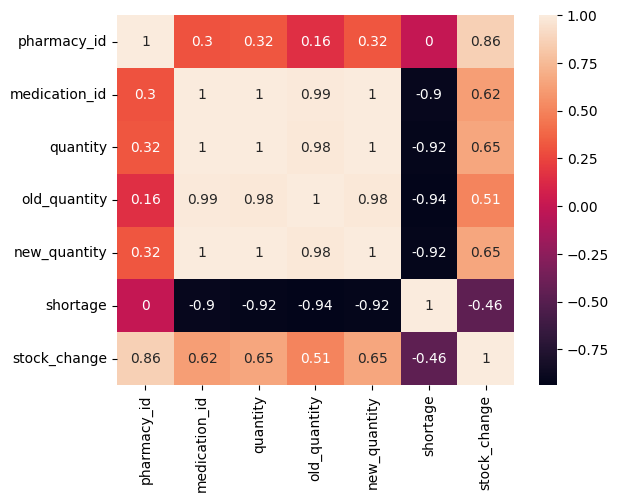

In [9]:
## 8. Feature Correlation
sns.heatmap(df.select_dtypes("number").corr(), annot=True)
plt.show()

In [10]:
## 9. Selected Features
features = [
    "quantity",
    "stock_change",
    "pharmacy_id",
    "medication_id"
]
target = "shortage"
